In [38]:
# Importar librerías
import pandas as pd
import urllib.request
import zipfile
import tempfile
import numpy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Descarga de datos
STATA_zip_url = 'https://observatorio.ministeriodesarrollosocial.gob.cl/storage/docs/casen/2022/Base%20de%20datos%20Casen%202022%20STATA_18%20marzo%202024.dta.zip'
STATA_file_name = 'Base de datos Casen 2022 STATA_18 marzo 2024.dta'

In [3]:
# Descargar y extraer los archivos
STATA_temp_file = tempfile.NamedTemporaryFile(delete=False)
STATA_zip_name = STATA_temp_file.name
urllib.request.urlretrieve(STATA_zip_url, STATA_zip_name)
with zipfile.ZipFile(STATA_zip_name, 'r') as zip_ref:
    zip_ref.extract(STATA_file_name)


In [4]:
# Leer los datos extraídos
data_STATA = pd.read_stata(STATA_file_name, convert_categoricals=False)

<ipython-input-4-10a4b651c867>:2: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  data_STATA = pd.read_stata(STATA_file_name, convert_categoricals=False)


In [5]:
# Limpieza de datos
data_STATA_cleaned = data_STATA.dropna(subset=['ytrabajocor'])  # Eliminar filas con valores nulos en 'ytrabajocor'
data_STATA_cleaned = data_STATA_cleaned.apply(pd.to_numeric, errors='coerce')  # Convertir todas las columnas a numéricas
data_STATA_cleaned = data_STATA_cleaned.dropna(thresh=0.5 * len(data_STATA_cleaned), axis=1)  # Eliminar columnas con más del 50% de valores nulos
data_STATA_cleaned = data_STATA_cleaned.fillna(data_STATA_cleaned.mean())  # Rellenar valores nulos con la media

In [6]:
# Normalización de datos
scaler = MinMaxScaler()
data_STATA_cleaned_normalized = pd.DataFrame(scaler.fit_transform(data_STATA_cleaned), columns=data_STATA_cleaned.columns)

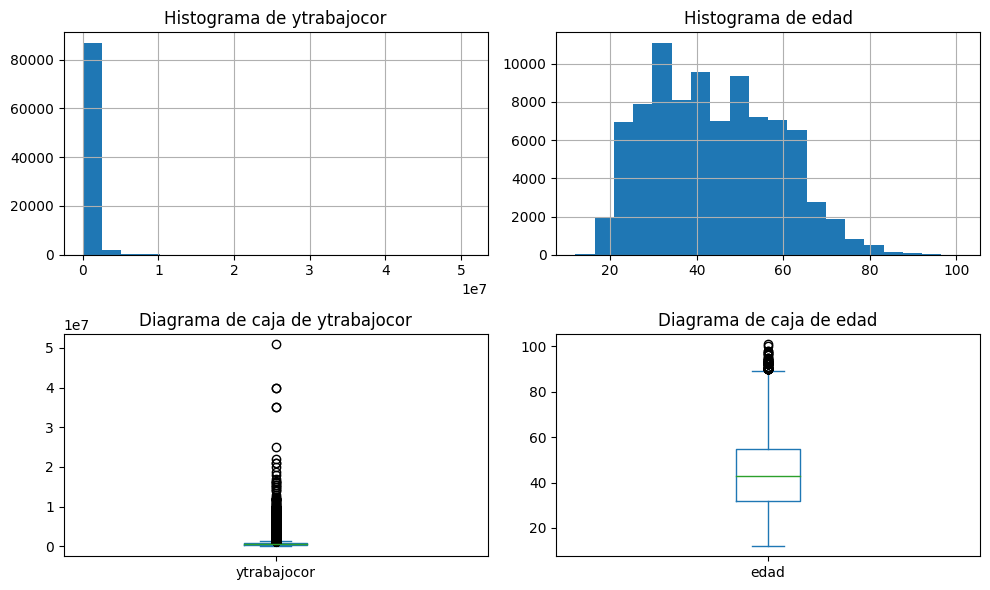

In [7]:
# Análisis descriptivo
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
data_STATA_cleaned['ytrabajocor'].hist(bins=20)
plt.title('Histograma de ytrabajocor')
plt.subplot(2, 2, 2)
data_STATA_cleaned['edad'].hist(bins=20)
plt.title('Histograma de edad')
plt.subplot(2, 2, 3)
data_STATA_cleaned['ytrabajocor'].plot.box()
plt.title('Diagrama de caja de ytrabajocor')
plt.subplot(2, 2, 4)
data_STATA_cleaned['edad'].plot.box()
plt.title('Diagrama de caja de edad')
plt.tight_layout()
plt.show()

In [8]:
# Selección de variables importantes
X = data_STATA_cleaned_normalized.drop('ytrabajocor', axis=1)
y = data_STATA_cleaned_normalized['ytrabajocor']
rfe = RFE(estimator=LinearRegression(), n_features_to_select=8)
X_rfe = rfe.fit_transform(X, y)
columnas_seleccionadas = X.columns[rfe.get_support()]
print("Variables seleccionadas:", columnas_seleccionadas)

Variables seleccionadas: Index(['yautcor', 'ytotcor', 'yautcorh', 'yoprcor', 'yoprcorh', 'ytrabajocorh',
       'ypchtrabcor', 'ypchautcor'],
      dtype='object')


In [9]:
# Ajuste del modelo de regresión lineal múltiple
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2:.2f}")

R^2: 0.98


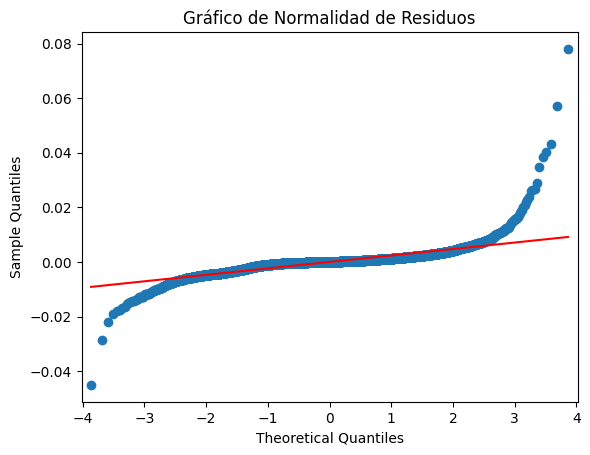

In [10]:
# Comprobación de condiciones de regresión lineal múltiple
residuos = y_test - y_pred
sm.qqplot(residuos, line='s')
plt.title("Gráfico de Normalidad de Residuos")
plt.show()

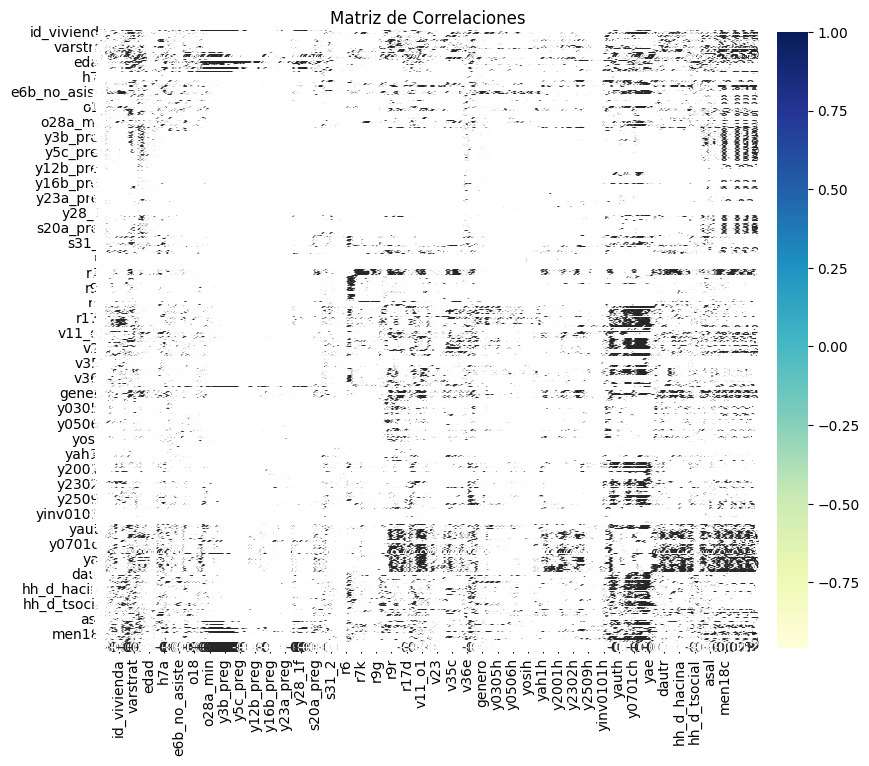

In [11]:
# Matriz de correlaciones
correlation_matrix = data_STATA_cleaned_normalized.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title("Matriz de Correlaciones")
plt.show()

In [13]:
# Interpretación de coeficientes
coef = pd.Series(model.coef_, index=columnas_seleccionadas)
print("Coeficientes del modelo:")
print(coef)

Coeficientes del modelo:
yautcor         1.144926
ytotcor        -0.410057
yautcorh       -0.260705
yoprcor         0.280488
yoprcorh       -0.224354
ytrabajocorh    0.501944
ypchtrabcor     0.290410
ypchautcor     -0.239274
dtype: float64


In [31]:
# Índices de error
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Error cuadrático medio (MSE): {mse:.2f}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse:.2f}")

Error cuadrático medio (MSE): 0.00
Raíz del error cuadrático medio (RMSE): 0.00


In [44]:
# Realizar una predicción
nuevos_datos = pd.DataFrame(columns=X_rfe.columns)
nuevos_datos.loc[0] = [0.5, 0.6, 0.7, 0.8, 0.9, 0.2, 0.3, 0.4]  # Reemplazar con los valores correspondientes
predicciones = model.predict(scaler.transform(nuevos_datos))
print("Predicciones:", predicciones)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

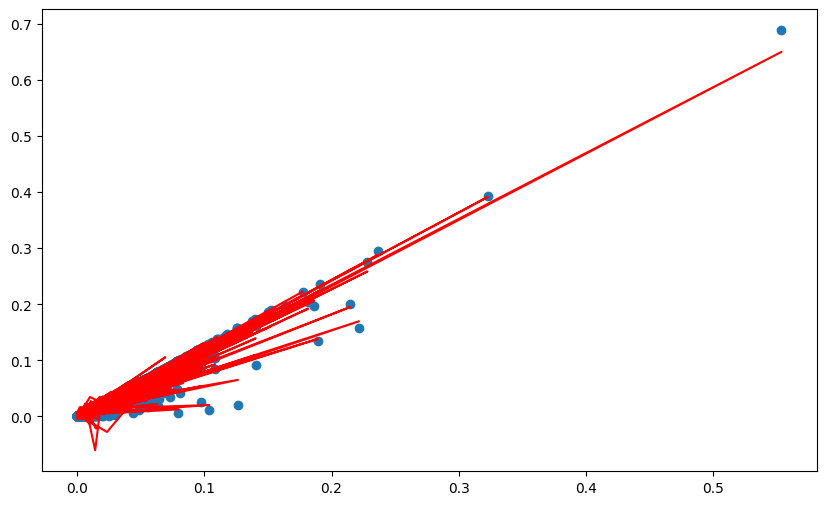

In [40]:
# Gráfico de la recta de regresión lineal múltiple
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], y_test, label='Datos reales')
plt.plot(X_test[:, 0], y_pred, color='red', label='Regresión lineal múltiple')
plt.xlabel(X_rfe.columns[0])
plt.ylabel('Variable objetivo')
plt.title('Gráfico de regresión lineal múltiple')
plt.legend()
plt.show()

In [39]:
# Discusión de mejoras del modelo
print("Posibles mejoras del modelo:")
print("- Explorar transformaciones de variables para mejorar la linealidad")
print("- Considerar modelos no lineales (ej. regresión polinomial, árboles de decisión)")
print("- Realizar una validación cruzada para una mejor estimación del rendimiento")
print("- Ajustar los hiperparámetros del modelo (ej. regularización)")
print("- Probar técnicas de ensemble (ej. Random Forest, Gradient Boosting)")

Posibles mejoras del modelo:
- Explorar transformaciones de variables para mejorar la linealidad
- Considerar modelos no lineales (ej. regresión polinomial, árboles de decisión)
- Realizar una validación cruzada para una mejor estimación del rendimiento
- Ajustar los hiperparámetros del modelo (ej. regularización)
- Probar técnicas de ensemble (ej. Random Forest, Gradient Boosting)
